# RecSys by books: solution with autoencoder

## Customization and import

In [5]:
import os
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import gridspec
from scipy import sparse
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [6]:
import warnings

warnings.filterwarnings("ignore")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
np.random.seed(42)
torch.manual_seed(42)

## Data

Significant description of books

In [9]:
df_1 = pd.read_csv(
    "./data/Books.csv",
    names=[
        "book_id",
        "book_title",
        "book_author",
        "publ_year",
        "publiser",
        "image_url_s",
        "image_url_m",
        "image_url_l",
    ],
)

In [10]:
df_1.sample(5)

,book_id,book_title,book_author,publ_year,publiser,image_url_s,image_url_m,image_url_l
103740,0671732838,SIX WEEKS TO WORDS OF POWER,Wilfred Funk,1990,Pocket,http://images.amazon.com/images/P/0671732838.0...,http://images.amazon.com/images/P/0671732838.0...,http://images.amazon.com/images/P/0671732838.0...
195299,3789119520,Eine Woche voller Samstage. ( Ab 8 J.).,Paul Maar,1973,Oetinger Verlag,http://images.amazon.com/images/P/3789119520.0...,http://images.amazon.com/images/P/3789119520.0...,http://images.amazon.com/images/P/3789119520.0...
161791,0345315413,David Starr: Space Ranger,Isaac Asimov,1984,Del Rey Books,http://images.amazon.com/images/P/0345315413.0...,http://images.amazon.com/images/P/0345315413.0...,http://images.amazon.com/images/P/0345315413.0...
184788,0394170016,The Complete Plays,Joe Orton,1977,Grove Press,http://images.amazon.com/images/P/0394170016.0...,http://images.amazon.com/images/P/0394170016.0...,http://images.amazon.com/images/P/0394170016.0...
161347,0312989717,Acrobat,Gonzalo Lira,2003,St. Martin's Paperbacks,http://images.amazon.com/images/P/0312989717.0...,http://images.amazon.com/images/P/0312989717.0...,http://images.amazon.com/images/P/0312989717.0...


Book ratings

In [11]:
with open("./data/Ratings.csv", errors="ignore") as fr:
    data = fr.read()
df = pd.read_csv(io.StringIO(data), sep=";", error_bad_lines=False)

In [12]:
df.columns = ["user_id", "book_id", "rating"]
df.sample(5)

,user_id,book_id,rating
1068833,255218,0684803860,0
1050349,251152,0471352292,5
1091286,261829,0373058772,0
734040,177432,0451169514,8
499815,120598,0821758551,7


Indicative description of clients

In [13]:
df_3 = pd.read_csv("./data/Users.csv", names=["user_id", "location", "age"])

In [14]:
df_3.sample(5)

,user_id,location,age
131212,131212,"los angeles, california, usa",NaN
241524,241524,"reno, nevada, usa",16.0
253057,253057,"london, london, united kingdom",NaN
53435,53435,"bushnell, florida, usa",NaN
141337,141337,"singapore, n/a, singapore",26.0


## EDA

### Ratings

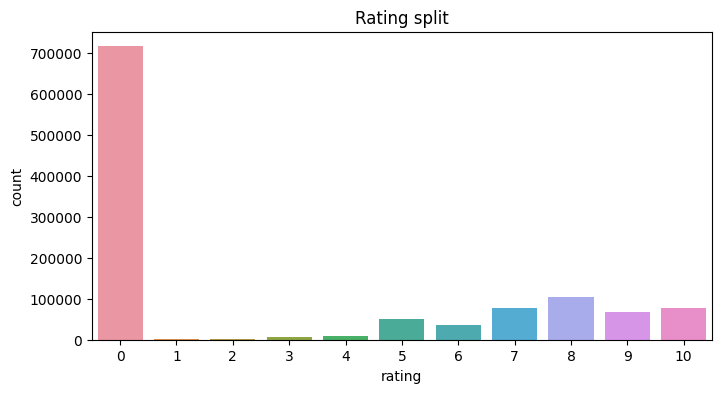

In [18]:
plt.figure(figsize=(8, 4))
ax = sns.countplot(x=df["rating"])
ax.set_title("Rating split")

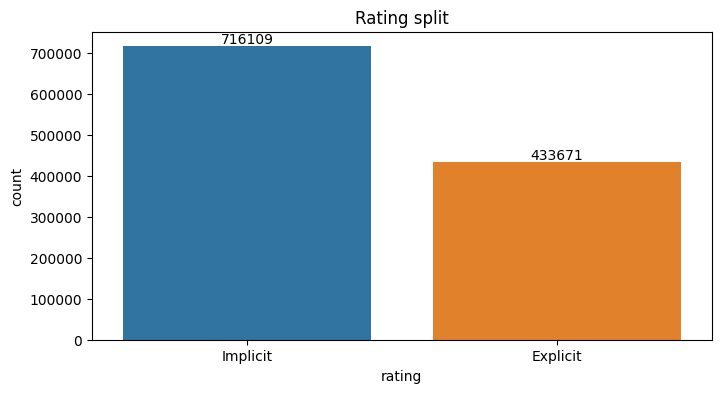

In [19]:
plt.figure(figsize=(8, 4))
imp_vs_exp = df["rating"].apply(lambda x: "Implicit" if x == 0 else "Explicit")

ax = sns.countplot(x=imp_vs_exp)
ax.bar_label(
    container=ax.containers[0], labels=imp_vs_exp.value_counts().values.round(3)
)
ax.set_title("Rating split")

Lines with a zero rating are useless, but at the same time they make up a massive layer of data.

In [20]:
# Remove useless rows with 0 rating
df = df[df["rating"] != 0]

In [31]:
df

,user_id,book_id,rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


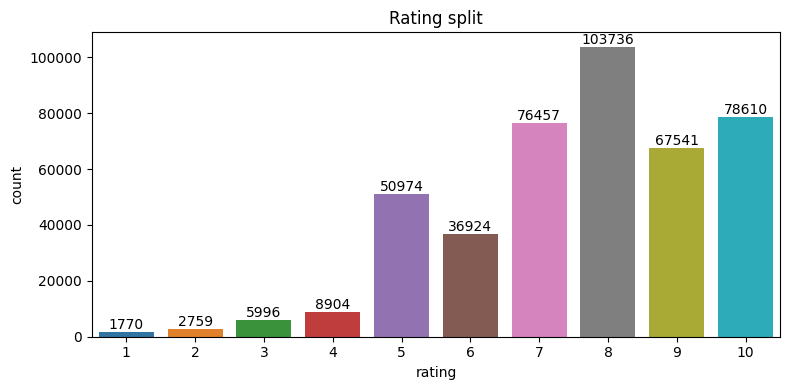

In [21]:
plt.figure(figsize=(8, 4))
explicit_rate = df["rating"]

ax = sns.countplot(x=explicit_rate)
ax.bar_label(
    container=ax.containers[0],
    labels=explicit_rate.value_counts().sort_index().values.round(3),
)
ax.set_title("Rating split")
plt.tight_layout()

Judging by the scatter (a rare number of negative reviews), it can be assumed that the entire ballroom school is meaningful.

In [22]:
df.describe()

,user_id,rating
count,433671.000000,433671.000000
mean,135458.743451,7.601066
std,80678.385078,1.843798
min,8.000000,1.000000
25%,66619.000000,7.000000
50%,133184.000000,8.000000
75%,205735.000000,9.000000
max,278854.000000,10.000000


The average rating is high.

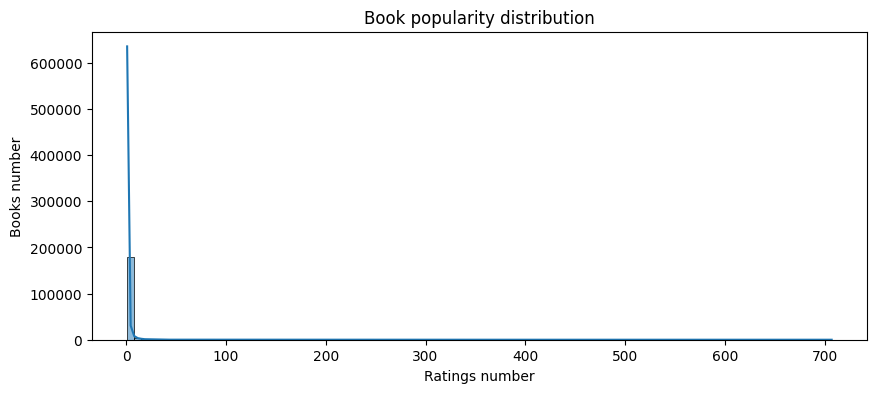

In [33]:
plt.figure(figsize=(10, 4))
ax = sns.histplot(
    data=df.groupby(["book_id"]).size().reset_index(name="counts"),
    x="counts",
    bins=100,
    kde=True,
)
ax.set_xlabel("Ratings number")
ax.set_ylabel("Books number")
ax.set_title("Book popularity distribution")

Most books have few ratings.

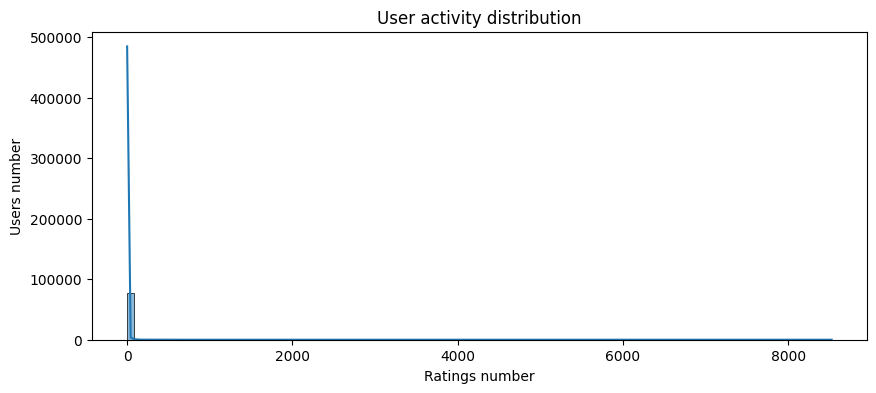

In [24]:
plt.figure(figsize=(10, 4))
ax = sns.histplot(
    data=df.groupby(["user_id"]).size().reset_index(name="counts"),
    x="counts",
    bins=100,
    kde=True,
)
ax.set_xlabel("Ratings number")
ax.set_ylabel("Users number")
ax.set_title("User activity distribution")

In terms of user activity, there is a similar picture, the longer tail of the distribution is due to the user who left:

In [25]:
max_user_ratings = (
    df.groupby(["user_id"]).size().reset_index(name="counts").max().counts
)

In [26]:
max_user_ratings

8524

## Data preparation

### Treatment

In [117]:
file = "./data/Ratings.csv"
with open(file, errors="ignore") as fr:
    data = fr.read()
df = pd.read_csv(io.StringIO(data), sep=";", error_bad_lines=False)

In [118]:
df.columns = ["user_id", "book_id", "rating"]
df.sample(5)

,user_id,book_id,rating
525624,127233,0060096195,0
1065755,254498,8806159356,0
507700,123608,0590332767,6
899214,217375,0743462939,0
463270,110973,0373106149,0


In [119]:
# Remove useless rows with 0 rating
df = df[df["rating"] != 0]

Let's weed out:
- users with few reviews (`< user_lim`)
- books with few reviews (`< item_lim`)

In [120]:
def count_per_item(df, column_name: str):
    item_groups = df.groupby([column_name], as_index=False).size()
    return item_groups

In [121]:
# Filter over dataframe iteratively until nothing could be removed by condition
def filter_by_limits(df, user_lim=9, item_lim=9):

    while True:
        end_cycle = False
        if user_lim > 0:
            user_groups = count_per_item(df, "user_id")
            n_users = len(user_groups)
            df = df[
                df["user_id"].isin(
                    user_groups[user_groups["size"] > user_lim].user_id.values
                )
            ]

            # Check if smth was removed in this step
            if df["user_id"].nunique() == n_users:
                end_cycle = True

        if item_lim > 0:
            book_groups = count_per_item(df, "book_id")
            n_books = len(book_groups)
            df = df[
                df["book_id"].isin(
                    book_groups[book_groups["size"] > item_lim].book_id.values
                )
            ]

            if end_cycle and df["book_id"].nunique() == n_books:
                break

    print(f"Оставили {df['user_id'].nunique()} уникальных пользователей", end="\n")
    print(f"Оставили {df['book_id'].nunique()} уникальных книг")

    user_groups, book_groups = count_per_item(df, "user_id"), count_per_item(
        df, "book_id"
    )
    return df, user_groups, book_groups

In [122]:
df, user_groups, book_groups = filter_by_limits(df)

Оставили 1842 уникальных пользователей
Оставили 2065 уникальных книг


In [123]:
df.sample(5)

,user_id,book_id,rating
408264,98391,0425188361,10
415974,98787,0385498802,6
856726,207148,0688170528,9
743198,179772,0140067477,10
507312,123515,0312966970,8


### Test-split 

In [124]:
unique_users_id = user_groups.user_id.values
unique_books_id = pd.unique(df["book_id"])

n_users = len(unique_users_id)
n_books = len(unique_books_id)

In [125]:
# Shuffle user_ids
np.random.shuffle(unique_users_id)

In [126]:
n_heldout_users = int(0.2 * n_users)

# Split Train/Test by indices
train_users = unique_users_id[: (n_users - n_heldout_users)]
print(f"Размер выборки для обучения: {len(train_users)}")
test_users = unique_users_id[(n_users - n_heldout_users) :]
print(f"Размер выборки для тестирования: {len(test_users)}")

Размер выборки для обучения: 1474
Размер выборки для тестирования: 368


## Saving data for the Dataset class 

In [127]:
train_df = df.loc[df["user_id"].isin(train_users)]
train_df = train_df.sort_values(["user_id"])

In [128]:
test_df = df.loc[df["user_id"].isin(test_users)]
test_df = test_df.sort_values(["user_id"])

Reindexing

In [129]:
def reindex_mappings(df, train_df, test_df):

    # First reindex train dataframe
    users_id = train_df.user_id.values

    user_to_ind = {}

    for user in users_id:
        if user not in user_to_ind:
            user_to_ind[user] = user_to_ind.__len__()

    # Complete reindexing by using test df
    user_id = test_df.user_id.values

    for user in user_id:
        if user not in user_to_ind:
            user_to_ind[user] = user_to_ind.__len__()

    book_to_ind = {}

    books = df.book_id.values

    for book in books:
        if book not in book_to_ind:
            book_to_ind[book] = book_to_ind.__len__()

    return user_to_ind, book_to_ind

In [130]:
def apply_reindex(df):
    global user_to_ind, book_to_ind
    df["user_id"] = df["user_id"].apply(lambda x: user_to_ind[x])
    df["book_id"] = df["book_id"].apply(lambda x: book_to_ind[x])

In [131]:
user_to_ind, book_to_ind = reindex_mappings(df, train_df, test_df)

### Train data

In [132]:
apply_reindex(train_df)

In [133]:
# Save train data
data_dir = os.path.join(os.getcwd(), "dataset_data")

if not os.path.exists(data_dir):
    os.makedirs("dataset_data")

In [134]:
train_df.to_csv(os.path.join(data_dir, "train.csv"), index=False)

### Test data

In [135]:
apply_reindex(test_df)

It is important to understand that the existence of the "cold start" problem obliges the test sample to also be divided into two parts: the first part `test_input` will be fed into the model (imitation of a user with certain interests), and according to the reconstruction obtained from the model, we will additionally predict the user's interests and data the second part `test_compare` will allow comparison, thereby evaluating the quality of the reconstruction.

In [136]:
# Split test data into two parts: one as input for model
# and another one as a comparison with reconstruction results
def split_test_data(df, proportion=0.3):
    user_groups = df.groupby("user_id")
    list_input, list_compare = [], []

    # np.random.seed(42)

    for _, group in user_groups:
        n_user_books = len(group)

        idx = np.zeros(n_user_books, dtype="bool")
        idx[
            np.random.choice(
                n_user_books, size=int(proportion * n_user_books), replace=False
            )
        ] = True

        list_input.append(group[~idx])
        list_compare.append(group[idx])

    df_input = pd.concat(list_input)
    df_compare = pd.concat(list_compare)

    return df_input, df_compare

In [137]:
test_df_input, test_df_compare = split_test_data(test_df)

In [138]:
test_df_input.to_csv(os.path.join(data_dir, "test_input.csv"), index=False)
test_df_compare.to_csv(os.path.join(data_dir, "test_compare.csv"), index=False)

### Save books ids 

In [139]:
books_ids = train_df.book_id.unique()
with open(os.path.join(data_dir, "books_ids.txt"), "w") as f:
    for book_id in books_ids:
        f.write(f"{book_id}\n")

Everything is ready to create a dataset class for training and testing the model.

## Class dataset

In [140]:
class BookTrainDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        super(BookTrainDataset, self).__init__()
        self.dir = os.path.join(path, "dataset_data")
        self.n_books = self._get_n_books()

        self.matrix = self._extract_train_data()

    @property
    def sparsity(self):
        return self.matrix.count_nonzero().item() / torch.numel(self.matrix)

    def _get_n_books(self):
        path = os.path.join(self.dir, "books_ids.txt")

        books_ids = []
        with open(path, "r") as f:
            for line in f:
                books_ids.append(line.strip())
        n_books = len(books_ids)
        return n_books

    def _extract_train_data(self):
        path = os.path.join(self.dir, "train.csv")

        train_df = pd.read_csv(path)
        ratings = train_df["rating"].values

        n_users = len(train_df.groupby("user_id").size())

        rows, cols = train_df["user_id"].values, train_df["book_id"].values
        data = sparse.csr_matrix(
            (ratings, (rows, cols)),
            dtype="float64",
            shape=(n_users, self.n_books),
        )
        return self.sparse_to_torch(data)

    @staticmethod
    def sparse_to_torch(data):
        data = data.toarray()  # to dense ndarray
        data = torch.FloatTensor(data)  # to dense torch.Tensor
        # Min-max normalization
        min_val, max_val = data.min(), data.max()
        data = (data - min_val) / (max_val - min_val)
        return data

    def __len__(self):
        return len(self.matrix)

    def __getitem__(self, idx):
        return self.matrix[idx]

In [141]:
class BookTestDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        super(BookTestDataset, self).__init__()
        self.dir = os.path.join(path, "dataset_data")
        self.n_books = self._get_n_books()

        self.matrix_input, self.matrix_compare = self._extract_test_data()

    @property
    def sparsity(self):
        return self.matrix_input.count_nonzero().item() / torch.numel(
            self.matrix_input
        ), self.matrix_compare.count_nonzero().item() / torch.numel(self.matrix_compare)

    def _get_n_books(self):
        path = os.path.join(self.dir, "books_ids.txt")

        books_ids = []
        with open(path, "r") as f:
            for line in f:
                books_ids.append(line.strip())
        n_books = len(books_ids)
        return n_books

    def _extract_test_data(self):
        path_input = os.path.join(self.dir, "test_input.csv")
        path_compare = os.path.join(self.dir, "test_compare.csv")

        # Have equal number of users
        test_df_input = pd.read_csv(path_input)
        test_df_compare = pd.read_csv(path_compare)

        ratings_input = test_df_input["rating"].values
        ratings_compare = test_df_compare["rating"].values

        # Reindex to meet dimension boundaries
        start_idx = test_df_input["user_id"].min()
        end_idx = test_df_input["user_id"].max()
        n_users = end_idx - start_idx + 1

        rows_input, cols_input = (
            test_df_input["user_id"] - start_idx,
            test_df_input["book_id"],
        )
        rows_compare, cols_compare = (
            test_df_compare["user_id"] - start_idx,
            test_df_compare["book_id"],
        )

        data_input = sparse.csr_matrix(
            (ratings_input, (rows_input, cols_input)),
            dtype="float64",
            shape=(n_users, self.n_books),
        )

        data_compare = sparse.csr_matrix(
            (ratings_compare, (rows_compare, cols_compare)),
            dtype="float64",
            shape=(n_users, self.n_books),
        )

        return self.sparse_to_torch(data_input), self.sparse_to_torch(data_compare)

    @staticmethod
    def sparse_to_torch(data):
        data = data.toarray()  # to dense ndarray
        data = torch.FloatTensor(data)  # to dense torch.Tensor
        # Min-max normalization
        min_val, max_val = data.min(), data.max()
        data = (data - min_val) / (max_val - min_val)
        return data

    def __len__(self):
        # Both matrices have the same length
        return len(self.matrix_input)

    def __getitem__(self, idx):
        return (
            self.matrix_input[idx],
            self.matrix_compare[idx],
        )

In [142]:
train_dataset = BookTrainDataset(path=os.getcwd())
test_dataset = BookTestDataset(path=os.getcwd())

In [143]:
print(f"Train matrix sparsity: {train_dataset.sparsity}")
print(f"\nTest matrix (as model input) sparsity: {test_dataset.sparsity[0]}")
print(
    f"\nTest matrix (as holdout for metric evaluation) sparsity: {test_dataset.sparsity[1]}"
)

Train matrix sparsity: 0.01074410032163637

Test matrix (as model input) sparsity: 0.00888514580482156

Test matrix (as holdout for metric evaluation) sparsity: 0.0035293188756711233


## Model

In [224]:
class DenoisingAE(torch.nn.Module):
    @property
    def device(self):
        """Moves all model parameters to the device."""
        return next(self.parameters()).device

    def __init__(
        self,
        enc_dims: List[int],
        dec_dims: Optional[List[int]] = None,
        corrupt_ratio: float = 0.3,
    ):
        super(DenoisingAE, self).__init__()
        self.enc_dims = enc_dims
        if dec_dims:
            assert (
                enc_dims[0] == dec_dims[-1]
            ), "Reconstruction dimension should be equal to input"
            assert (
                enc_dims[-1] == dec_dims[0]
            ), "Latent dimension for encoder and decoder should be equal"
            self.dec_dims = dec_dims
        else:
            # Decoder is symmetric by default
            self.dec_dims = enc_dims[::-1]

        self.activation_fn = torch.nn.Sigmoid()
        self.corrupt_ratio = corrupt_ratio

        self.dims = self.enc_dims + self.dec_dims[1:]
        self.layers = torch.nn.ModuleList(
            [
                torch.nn.Linear(d_in, d_out)
                for d_in, d_out in zip(self.dims[:-1], self.dims[1:])
            ]
        )

    def forward(self, input):
        if self.corrupt_ratio:
            # Corrupt the rating matrix only during training
            h = torch.nn.functional.dropout(
                input, p=self.corrupt_ratio, training=self.training
            )
        for i, layer in enumerate(self.layers):
            h = layer(h)
            # No activation on the last decoding layer
            if i != len(self.layers) - 1:
                h = self.activation_fn(h)
        return h

### Model initialization

In [145]:
input_dim = train_dataset.n_books

In [146]:
enc_dims = [input_dim, 200, 10]
model = DenoisingAE(enc_dims)
_ = model.to(device)

In [147]:
# Test
y = torch.rand(5, input_dim)
output = model(y)
assert output.size() == (5, input_dim)

## Code for training the model

torch.nn.MSEloss() does not have an ignore_index parameter, so you need to take into account

In [148]:
def train_on_batch(model, batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    batch = batch.to(device)

    recon_batch = model(batch)

    # Compute MSE loss
    recon_batch[batch == 0] = 0
    unreduced_loss = loss_function(recon_batch, batch)
    reduced_loss = torch.masked_select(unreduced_loss, unreduced_loss != 0).mean()
    reduced_loss.backward()

    optimizer.step()

    return reduced_loss.to("cpu").item()

In [149]:
def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0.0
    for batch in train_generator:
        batch_loss = train_on_batch(model, batch, optimizer, loss_function)

        if callback is not None:
            model.eval()
            with torch.no_grad():
                callback(model, batch_loss)

        epoch_loss += batch_loss
    rmse = np.sqrt(epoch_loss)
    return rmse

In [150]:
def trainer(
    count_of_epoch,
    batch_size,
    dataset,
    model,
    loss_function,
    optimizer,
    lr,
    wd,
    callback=None,
):

    optima = optimizer(model.parameters(), lr=lr, weight_decay=wd)

    iterations = tqdm(range(count_of_epoch), desc="epoch")
    iterations.set_postfix({"train epoch rmse": np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(
                dataset=dataset, batch_size=batch_size, shuffle=True
            ),
            leave=False,
            total=len(dataset) // batch_size + (len(dataset) % batch_size > 0),
        )

        epoch_loss = train_epoch(
            train_generator=batch_generator,
            model=model,
            loss_function=loss_function,
            optimizer=optima,
            callback=callback,
        )

        iterations.set_postfix({"train epoch rmse": epoch_loss})

In [166]:
class Сallback:
    def __init__(
        self, writer, dataset, loss_function, delimeter=1, batch_size=len(test_dataset)
    ):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size
        self.dataset = dataset
        self.model = model

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar("MSE_LOSS/train", loss, self.step)

        if self.step % self.delimeter == 0:
            total_mse, r10, r20, p10, p20 = self._testing(model)

            self.writer.add_scalar("MSE_LOSS/test", total_mse, self.step)
            self.writer.add_scalar("Recall@10/test", r10, self.step)
            self.writer.add_scalar("Recall@20/test", r20, self.step)
            self.writer.add_scalar("Precision@10/test", p10, self.step)
            self.writer.add_scalar("Precision@20/test", p20, self.step)

    @staticmethod
    def recall_at_k(recon_batch, batch_true, k=5):
        batch_users = recon_batch.shape[0]

        # Find indexes of the first k recommendations
        idx = np.argpartition(-recon_batch, k, axis=1)

        # Convert it to binary
        recon_batch_binary = np.zeros_like(recon_batch, dtype=bool)
        recon_batch_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

        batch_true_binary = batch_true > 0

        # Compute recall
        intersection_cardinality = (
            (recon_batch_binary & batch_true_binary).sum(axis=1).astype(np.float32)
        )
        recall = intersection_cardinality / np.minimum(k, batch_true_binary.sum(axis=1))
        return recall

    @staticmethod
    def precision_at_k(recon_batch, batch_true, k=5):
        batch_users = recon_batch.shape[0]

        # Find indexes of the first k recommendations
        idx = np.argpartition(-recon_batch, k, axis=1)

        # Convert it to binary
        recon_batch_binary = np.zeros_like(recon_batch, dtype=bool)
        recon_batch_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

        batch_true_binary = batch_true > 0

        # Compute precision
        intersection_cardinality = (
            (recon_batch_binary & batch_true_binary).sum(axis=1).astype(np.float32)
        )
        precision = intersection_cardinality / k
        return precision

    def _testing(self, model):
        model.eval()
        total_mse = 0.0
        r10_list, r20_list = [], []
        p10_list, p20_list = [], []

        for batch_input, batch_true in torch.utils.data.DataLoader(
            dataset=self.dataset, batch_size=self.batch_size, shuffle=False
        ):
            batch_input = batch_input.to(device)
            # batch_compare = batch_compare.to(device) Check if it important or not
            with torch.no_grad():
                recon_batch = model(batch_input)

            # Compute MSE with synchronized reconstruction and true batches
            recon_batch_sync = recon_batch.clone().detach()
            recon_batch_sync[batch_true == 0] = 0

            unreduced_loss = self.loss_function(recon_batch_sync, batch_true)
            # Remove zeroes
            reduced_loss = torch.masked_select(unreduced_loss, unreduced_loss != 0)
            total_mse += reduced_loss.to("cpu").mean().item()

            # Compute other metrics
            recon_batch = recon_batch.to("cpu").numpy()
            # batch_compare = batch_compare.to("cpu").numpy()
            batch_true = batch_true.numpy()
            batch_input = batch_input.numpy()

            # Exclude known ratings that were used to build reconstruction
            recon_batch[batch_input.nonzero()] = float("-inf")

            r10 = recall_at_k(recon_batch, batch_true, 10)
            p10 = precision_at_k(recon_batch, batch_true, 10)
            r20 = recall_at_k(recon_batch, batch_true, 20)
            p20 = precision_at_k(recon_batch, batch_true, 20)

            r10_list.append(r10)
            p10_list.append(p10)
            r20_list.append(r20)
            p20_list.append(p20)

        r10_list, r20_list = np.concatenate(r10_list), np.concatenate(r20_list)
        p10_list, p20_list = np.concatenate(p10_list), np.concatenate(p20_list)

        return (
            total_mse,
            np.mean(r10_list),
            np.mean(r20_list),
            np.mean(p10_list),
            np.mean(p20_list),
        )

    def __call__(self, model, loss):
        return self.forward(model, loss)

## Code for model evaluation

### Metrics

In [152]:
def recall_at_k(recon_batch, batch_true, k=5):
    batch_users = recon_batch.shape[0]

    # Find indexes of the first k recommendations
    idx = np.argpartition(-recon_batch, k, axis=1)

    # Convert it to binary
    recon_batch_binary = np.zeros_like(recon_batch, dtype=bool)
    recon_batch_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    batch_true_binary = batch_true > 0

    # Compute recall
    intersection_cardinality = (
        (recon_batch_binary & batch_true_binary).sum(axis=1).astype(np.float32)
    )
    recall = intersection_cardinality / np.minimum(k, batch_true_binary.sum(axis=1))
    return recall

In [153]:
def precision_at_k(recon_batch, batch_true, k=5):
    batch_users = recon_batch.shape[0]

    # Find indexes of the first k recommendations
    idx = np.argpartition(-recon_batch, k, axis=1)

    # Convert it to binary
    recon_batch_binary = np.zeros_like(recon_batch, dtype=bool)
    recon_batch_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    batch_true_binary = batch_true > 0

    # Compute precision
    intersection_cardinality = (
        (recon_batch_binary & batch_true_binary).sum(axis=1).astype(np.float32)
    )
    precision = intersection_cardinality / k
    return precision

To calculate the metrics, it is necessary to sort `k` relevant predictions, for this, the known scores of the user of the book, stored in `batch_input`, must be excluded.

In [154]:
def testing(loss_function, model, dataset, batch_size):
    model.eval()
    total_loss = 0.0
    r10_list, r20_list = [], []
    p10_list, p20_list = [], []

    for batch_input, batch_true in torch.utils.data.DataLoader(
        dataset=dataset, batch_size=batch_size, shuffle=False
    ):
        batch_input = batch_input.to(device)
        # batch_compare = batch_compare.to(device) Check if it important or not
        with torch.no_grad():
            recon_batch = model(batch_input)

        # Compute MSE with synchronized reconstruction and true batches
        recon_batch_sync = recon_batch.clone().detach()
        recon_batch_sync[batch_true == 0] = 0

        unreduced_loss = loss_function(recon_batch_sync, batch_true)
        # Remove zeroes
        reduced_loss = torch.masked_select(unreduced_loss, unreduced_loss != 0)
        total_loss += reduced_loss.to("cpu").mean().item()

        # Compute other metrics
        recon_batch = recon_batch.to("cpu").numpy()
        # batch_compare = batch_compare.to("cpu").numpy()
        batch_true = batch_true.numpy()
        batch_input = batch_input.numpy()

        # Exclude known ratings that were used to build reconstruction
        recon_batch[batch_input.nonzero()] = float("-inf")

        r10 = recall_at_k(recon_batch, batch_true, 10)
        p10 = precision_at_k(recon_batch, batch_true, 10)
        r20 = recall_at_k(recon_batch, batch_true, 20)
        p20 = precision_at_k(recon_batch, batch_true, 20)

        r10_list.append(r10)
        p10_list.append(p10)
        r20_list.append(r20)
        p20_list.append(p20)

    r10_list, r20_list = np.concatenate(r10_list), np.concatenate(r20_list)
    p10_list, p20_list = np.concatenate(p10_list), np.concatenate(p20_list)
    total_rmse = np.sqrt(total_loss)

    return (
        total_rmse,
        np.mean(r10_list),
        np.mean(r20_list),
        np.mean(p10_list),
        np.mean(p20_list),
    )

## Model quality before training

In [156]:
mse = torch.nn.MSELoss(reduction="none")

In [157]:
total_rmse, r10, r20, p10, p20 = testing(mse, model, test_dataset, len(test_dataset))

In [158]:
print(f"Total RMSE: {total_rmse}")
print(f"\nTotal recall@10: {r10}")
print(f"\nTotal precision@10: {p10}")
print(f"\nTotal recall@20: {r20}")
print(f"\nTotal precision@20: {p20}")

Total RMSE: 0.8543293301836704

Total recall@10: 0.0036080917874396134

Total precision@10: 0.001902173855341971

Total recall@20: 0.0073195373467112605

Total precision@20: 0.002581521635875106


## Model training

In [167]:
loss_function = torch.nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam

In [168]:
writer = SummaryWriter(log_dir="main_train")
call = Сallback(writer, test_dataset, loss_function)

In [169]:
trainer(
    count_of_epoch=15,
    batch_size=128,
    dataset=train_dataset,
    model=model,
    loss_function=loss_function,
    optimizer=optimizer,
    lr=0.001,
    wd=0.01,
    callback=call,
)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [170]:
%load_ext tensorboard
%tensorboard --logdir main_train/

## Assessing the quality of the model after training

In [171]:
total_rmse, r10, r20, p10, p20 = testing(mse, model, test_dataset, len(test_dataset))

In [172]:
print(f"Total RMSE: {total_rmse}")
print(f"\nTotal recall@10: {r10}")
print(f"\nTotal precision@10: {p10}")
print(f"\nTotal recall@20: {r20}")
print(f"\nTotal precision@20: {p20}")

Total RMSE: 0.22503697700772388

Total recall@10: 0.030332341269841273

Total precision@10: 0.015760870650410652

Total recall@20: 0.05038066524996967

Total precision@20: 0.014266304671764374


## Iterate over space dimensions

Let's compare the prediction quality of a multi-layer autoencoder and a single-layer one.

### Single layer autoencoder

In [223]:
# for d in [512, 256, 128, 64, 32, 16, 8, 4, 2]:
#     enc_dims = [input_dim, d]
#     autoencoder = DenoisingAE(enc_dims)
#     _ = autoencoder.to(device)

#     writer = SummaryWriter(log_dir="onelayer_autoencoder/dim_{}".format(d))
#     call = Сallback(writer, test_dataset, loss_function)

#     trainer(
#         count_of_epoch=15,
#         batch_size=128,
#         dataset=train_dataset,
#         model=autoencoder,
#         loss_function=loss_function,
#         optimizer=optimizer,
#         lr=0.001,
#         wd=0.01,
#         callback=call,
#     )

In [177]:
%load_ext tensorboard
%tensorboard --logdir onelayer_autoencoder/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 62699), started 0:04:05 ago. (Use '!kill 62699' to kill it.)

For a single-layer autoencoder, the dimension of the hidden layer `d = 32` turned out to be optimal in terms of ranking quality metrics, while the MSE is higher than that of the dimensions `d > d = 32`.

In [179]:
autoencoder_32 = DenoisingAE([input_dim, 32])
_ = autoencoder_32.to(device)

trainer(
    count_of_epoch=15,
    batch_size=128,
    dataset=train_dataset,
    model=autoencoder_32,
    loss_function=loss_function,
    optimizer=optimizer,
    lr=0.001,
    wd=0.01,
    callback=None,
)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [182]:
total_rmse, r10, r20, p10, p20 = testing(
    mse, autoencoder_32, test_dataset, len(test_dataset)
)

In [183]:
print(f"Total RMSE: {total_rmse}")
print(f"\nTotal recall@10: {r10}")
print(f"\nTotal precision@10: {p10}")
print(f"\nTotal recall@20: {r20}")
print(f"\nTotal precision@20: {p20}")

Total RMSE: 0.4510571717936922

Total recall@10: 0.04232983954451345

Total precision@10: 0.023913046345114708

Total recall@20: 0.055995539151288576

Total precision@20: 0.017391305416822433


### Multilayer autoencoder

In [186]:
# # Ignore very little dimensions
# for d1 in [512, 256, 128, 64, 32, 16]:
#     for d2 in [16, 32, 64, 128, 256, 512]:
#         enc_dims = [input_dim, d1, d2]
#         autoencoder = DenoisingAE(enc_dims)
#         _ = autoencoder.to(device)

#         writer = SummaryWriter(log_dir=f"multilayer_autoencoder/dim1_{d1}/dim2_{d2}")
#         call = Сallback(writer, test_dataset, loss_function)

#         trainer(
#             count_of_epoch=15,
#             batch_size=128,
#             dataset=train_dataset,
#             model=autoencoder,
#             loss_function=loss_function,
#             optimizer=optimizer,
#             lr=0.001,
#             wd=0.01,
#             callback=call,
#         )

In [199]:
%load_ext tensorboard
%tensorboard --logdir multilayer_autoencoder/dim1_32

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6011 (pid 65135), started 16:23:36 ago. (Use '!kill 65135' to kill it.)

Comparing the quality of ranking, the optimal model for both metrics is the model with the dimensions of the layers:
`d1 = 32` and `d2 = 32`.

## Selection of training parameters

For this architecture, we select the optimal training parameters.

In [209]:
# for n_epoch in [10, 20, 50, 100]:
#     for lr in [0.0001, 0.001, 0.01]:
#         for wd in [0, 0.1, 0.01, 0.001]:
#             autoencoder32_32 = DenoisingAE([input_dim, 32, 32])
#             _ = autoencoder32_32.to(device)

#             writer = SummaryWriter(log_dir=f"test_32_32/lr_{lr}/epoch_{n_epoch}/wd_{wd}")
#             call = Сallback(writer, test_dataset, loss_function)

#             trainer(
#                 count_of_epoch=n_epoch,
#                 batch_size=128,
#                 dataset=train_dataset,
#                 model=autoencoder32_32,
#                 loss_function=loss_function,
#                 optimizer=optimizer,
#                 lr=lr,
#                 wd=0.01,
#                 callback=call,
#             )

In [210]:
%load_ext tensorboard
%tensorboard --logdir test_32_32/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6016 (pid 77857), started 1:51:56 ago. (Use '!kill 77857' to kill it.)

Best options:
- `count_of_epoch=10`
- `lr=0.001`
- `wd=0.01`

In [220]:
autoencoder32_32 = DenoisingAE([input_dim, 32, 32])
_ = autoencoder32_32.to(device)

trainer(
    count_of_epoch=10,
    batch_size=128,
    dataset=train_dataset,
    model=autoencoder32_32,
    loss_function=loss_function,
    optimizer=optimizer,
    lr=0.001,
    wd=0.01,
    callback=None,
)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [221]:
total_rmse, r10, r20, p10, p20 = testing(
    mse, autoencoder32_32, test_dataset, len(test_dataset)
)

In [222]:
print(f"Total RMSE: {total_rmse}")
print(f"\nTotal recall@10: {r10}")
print(f"\nTotal precision@10: {p10}")
print(f"\nTotal recall@20: {r20}")
print(f"\nTotal precision@20: {p20}")

Total RMSE: 0.4141933486327525

Total recall@10: 0.03526462215320911

Total precision@10: 0.020108696073293686

Total recall@20: 0.05556759788255447

Total precision@20: 0.017527174204587936


## Conclusions

- The main feature of the dataset is that there is little statistically significant data (users who have rated enough books / books that have a sufficient number of ratings), which is a problem. A good recommender system based on the autoencoder did not work out.
- Despite this training is successful -> MSE falls, ranking quality metrics increase by several tens of times in comparison with the random model. In the case of some architectures, an almost monotonous increase in precision and recall is observed. It was also confirmed that achieving a more satisfactory rating prediction quality does not necessarily lead to an improvement in the ranking quality.
- The indicators of the metrics of models with a single-layer architecture and a multi-layer one do not differ much, the dimension of the hidden layer `d=32` turned out to be optimal everywhere.
- A more advanced approach, which consists in building an autoencoder that takes into account additional features of the user and books (feature enrichment, solving the "cold start" problem), does not seem rational, since more data is needed to learn embeddings.